# Julia Physics Simulations

This notebook contains a bunch of simple physical systems, simulated and analyzed using Julia.

## Imports

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using Plots

## Free-falling object

In this section, we will simulate the falling of an object due to gravity, with no initial velocity or external forces applied to it.

The equation of motion for an object falling freely in a gravitational field is:
$$
    \frac{d^2 x}{d t^2} = - g
$$
(the acceleration is negative because we're taking positive $x$ to be upwards)

In [2]:
g = 9.81

function free_falling_object!(d²x, dx, x, p, t)
    @. d²x = -g
end

free_falling_object! (generic function with 1 method)

In [3]:
initial_height = 10.0
time_interval = (0.0, 15.0)

prob = SecondOrderODEProblem(free_falling_object!,
    [0.0], [initial_height],
    time_interval)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: ([0.0], [10.0])

### Callbacks

We are now going to define a series of continuous callbacks (events) and discrete callbacks, in order to add additional behavior to the simulation.

#### Ground collision callback

We will implement a continuous callback for detecting when the ball hits the ground. In this case, we'll flip its velocity and decrease it by a certain friction coefficient.

After the ball has hit the ground a few times and lost most of its kinetic energy, we'll want to stop the simulation to avoid having it fall through the Earth 😱 (due to numerical errors).

In [4]:
friction_coefficient = 0.75

function ball_hitting_the_ground_condition(u, t, integrator)
    dx, x = u
    x
end

function ball_hitting_the_ground_affect!(integrator)
    integrator.u[1] = -integrator.u[1] * friction_coefficient

    # If we're taking some big timesteps
    if integrator.dt > 1e-10
        # Reduce the timestep considerably
        previous_dt = integrator.t - integrator.tprev
        set_proposed_dt!(integrator, previous_dt / 10)
    else
        # Stop the ball to avoid it going through the floor
        integrator.u[1] = dx = 0
        integrator.u[2] = x = 0
        terminate!(integrator)
    end
end

ground_hit_callback = ContinuousCallback(ball_hitting_the_ground_condition, ball_hitting_the_ground_affect!);

#### Ball kick callback

Now we'll add a discrete callback to simulate the kicking of the ball at a certain timestamp. This is implemented as an instantaneous increase of the ball's velocity.

In [5]:
ball_kicking_time = 4
ball_kicking_Δv = 7

function ball_kicking_affect!(integrator)
    integrator.u[1] += ball_kicking_Δv
end

ball_kicking_callback = PresetTimeCallback(ball_kicking_time, ball_kicking_affect!);

#### Composing all of the callbacks together

In [6]:
callback_set = CallbackSet(ground_hit_callback, ball_kicking_callback);

### Solving the problem

In [7]:
sol = solve(prob, DPRKN12(), callback = callback_set);
println("Solution terminated with return code `$(sol.retcode)`")
println("Solution length: $(length(sol)) savepoints")

Solution terminated with return code `Terminated`
Solution length: 346 savepoints


### Plotting the result

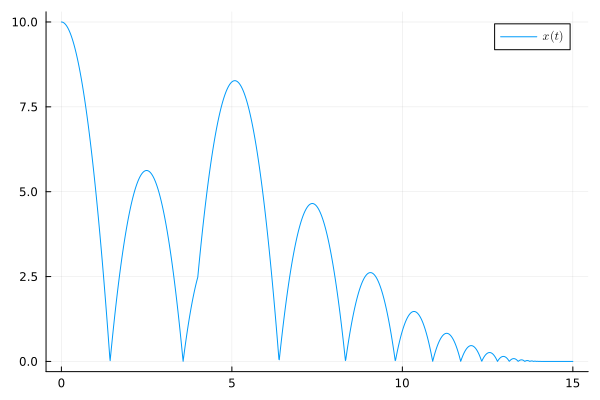

In [8]:
time_axis = range(time_interval[1], time_interval[2], step = 0.01)

plot(t -> sol(t)[2], time_axis, label = "\$x \\, (t)\$")
# plot!(t -> sol(t)[1], time_axis, label = "\$\\dot{x} \\, (t)\$")

## Simple pendulum

In this section, we will simulate the motion of a [simple pendulum](https://en.wikipedia.org/wiki/Pendulum_(mechanics)) (i.e. perfectly taught wire, no friction or other external forces).

We'll start by defining some physical constants related to our problem:

In [9]:
g = 9.81;
l = 1.0;

### Equation of motion

Simple pendulum with no external forces:
$$
    \frac{d^2 \theta}{d t^2} + \frac{g}{l} \sin (\theta) = 0
$$

Small-angle approximation ($\theta \ll 0.1, \sin (\theta) \approx \theta$):
$$
    \frac{d^2 \theta}{d t^2} + \frac{g}{l} \theta = 0
$$

In [10]:
function simple_pendulum!(d²θ, dθ, θ, p, t)
    @. d²θ = -g/l * sin(θ)
end

simple_pendulum! (generic function with 1 method)

### Solving the equation of motion

When initializing the ODE problem, we'll set the initial angle to be $\frac{\pi}{2}$ (90 degrees) and the initial velocity to be $0$.

In [11]:
θ₀ = π/2
dθ₀ = 0.0
;

We'll also define some helper functions to extract the energies of the system:
$$
\begin{gather*}
    KE = \frac{d\theta^2}{2} \\[0.5em]
    PE = l g (1 - \cos(\theta)) \\[0.5em]
    TE = KE + PE
\end{gather*}
$$

In [12]:
kinetic_energy(dθ) = dθ^2/2
potential_energy(θ) = l * g * (1 - cos(θ))
total_energy(dθ, θ) = kinetic_energy(dθ) + potential_energy(θ)
;

In [13]:
struct SystemEnergies
    kinetic::Float64
    potential::Float64
    total::Float64
end

saved_energies = SavedValues(Float64, SystemEnergies);

In [14]:
function extract_energy(u, t, integrator)
    dθ, θ = u
    KE = kinetic_energy(dθ)
    PE = potential_energy(θ)
    TE = KE + PE
    SystemEnergies(KE, PE, TE)
end

energy_saving_callback = SavingCallback(extract_energy, saved_energies);

In [15]:
correct_total_energy = total_energy(dθ₀, θ₀)

function compute_energy_residuals!(resid, u, p, t)
    dθ, θ = u
    resid[1] = total_energy(dθ, θ) - correct_total_energy
    resid[2] = 0
end

energy_conservation_callback = ManifoldProjection(compute_energy_residuals!);

In [16]:
callback = CallbackSet(
    energy_saving_callback, 
    # Uncomment to activate manifold projection and enforce conservation of total energy:
    energy_conservation_callback
);

In [17]:
time_interval = (0.0, 4π)

prob = SecondOrderODEProblem(simple_pendulum!, [dθ₀], [θ₀], time_interval)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 12.566370614359172)
u0: ([0.0], [1.5707963267948966])

In [18]:
sol = solve(prob, DPRKN6(), callback = callback);

In [19]:
time_range = range(time_interval[begin], time_interval[end], step = 0.05)
trajectory = sol.(time_range);

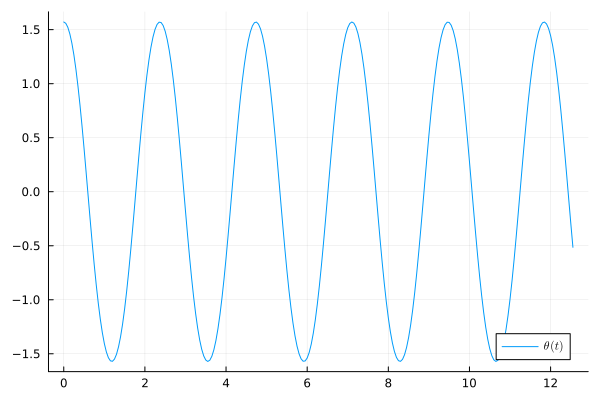

In [20]:
plot(time_range, getindex.(trajectory, 2), label = raw"$θ \, (t)$")
# plot!(t -> π/2 * cos(√(g/l) * t), time_range, label = raw"$\cos \, \left(\omega t\right)$", opacity = 0.4)

#### Phase space plot

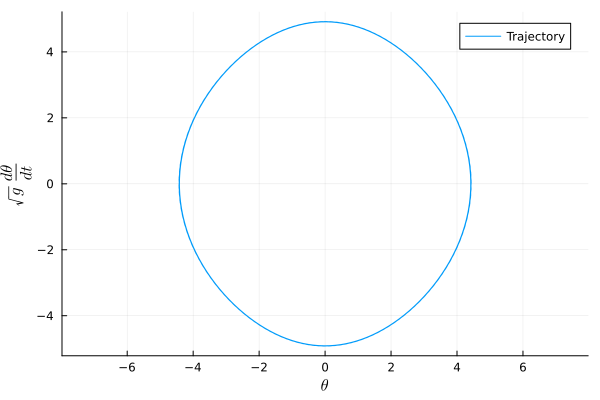

In [21]:
plot(getindex.(trajectory, 1), sqrt(g) * getindex.(trajectory, 2),
    idxs = (1, 2), label = "Trajectory",
    xlabel = raw"$θ$", ylabel = raw"$\sqrt{g} \, \frac{dθ}{dt}$",
    aspect_ratio = :equal)

### Energy analysis

Let's look at the system from the perspective of energy.

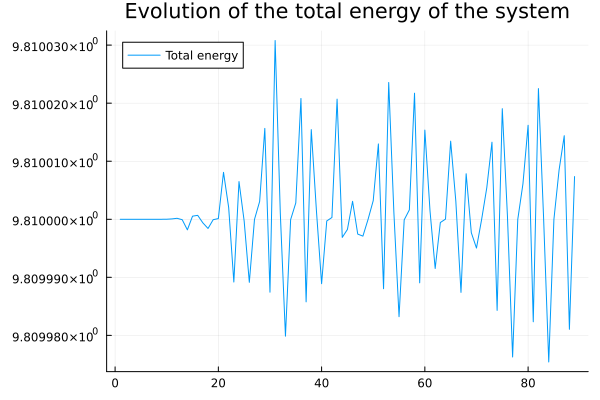

In [22]:
plot(getproperty.(saved_energies.saveval, :total),
    title = "Evolution of the total energy of the system",
    label = "Total energy")

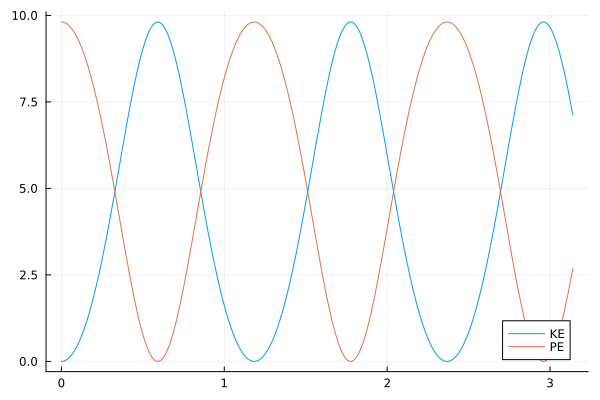

In [23]:
plot(t -> kinetic_energy(sol(t)[1]), 0:0.01:π, label = "KE")
# plot!(t -> (dθ₀ * cos(√(g/l) * t))^2/2, 0:0.01:π, label = "KE (analytic, for small-angle approximation)", opacity = 0.4)
plot!(t -> potential_energy(sol(t)[2]), 0:0.01:π, label = "PE")
# plot!(t -> dθ₀^2/2 * (1 - cos(dθ₀ * sin(√(g/l) * t))), 0:0.01:π, label = "PE (analytic, for small-angle approximation)", opacity = 0.4)

We can see that the total energy of the system (the sum of the kinetic and potential energies) is _almost_ constant. Unfortunately, the small deviation from a constant value is what will cause the solution to move away from the periodic behavior we'd expect.

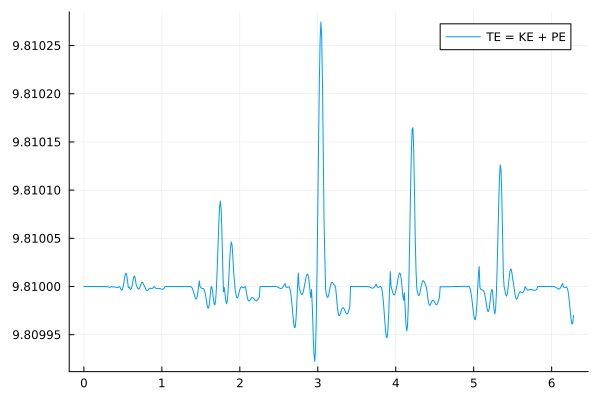

In [24]:
plot(t -> total_energy(sol(t)...), 0:0.01:2π, label = "TE = KE + PE")

## Driven oscillator

In this section, we will analyze a _driven oscillator_: a pendulum with a (periodic) external torque applied to it.

In [25]:
function driven_oscillator!(d²θ, dθ, u, p, t)
    @. d²θ = -g/l * sin(u) - p * sin(2π* t)
end

driven_oscillator! (generic function with 1 method)

In [26]:
prob = SecondOrderODEProblem(driven_oscillator!, [dθ₀], [θ₀], time_interval)

ODEProblem with uType RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 12.566370614359172)
u0: ([0.0], [1.5707963267948966])

In [27]:
frequency_interval = (0.5, 8)
interval_length = frequency_interval[2] - frequency_interval[1]

trajectories = 10

function prob_func(prob, i, repeat)
    new_frequency = frequency_interval[1] + (i - 1) * interval_length / trajectories
    remake(prob, p = new_frequency)
end

ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)

EnsembleProblem with problem ODEProblem

In [28]:
sim = solve(ensemble_prob, DPRKN6(), EnsembleThreads(), trajectories = trajectories);

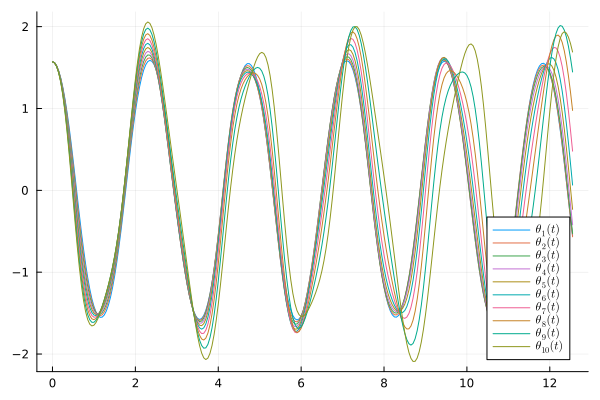

In [29]:
plot()
for (i, sol) in enumerate(sim)
    plot!(t -> sol(t)[2], 0:0.05:4π, label = "\$θ_{$i}(t)\$")
end
plot!()